## Environment Setup

**Upload following files to current directory**

1.   *requirements.txt*
2.   *dataloader.py*
3.   *capsule_network.py*
4.   *ccm_pruner.py*
5.   *utils.py*
6.   *model_train_test.py*

In [ ]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}"'.format(name=fn))

Saving capsule_network.py to capsule_network.py
Saving ccm_pruner.py to ccm_pruner.py
Saving dataloader.py to dataloader.py
Saving model_train_test.py to model_train_test.py
Saving requirements.txt to requirements.txt
Saving utils.py to utils.py
User uploaded file "capsule_network.py"
User uploaded file "ccm_pruner.py"
User uploaded file "dataloader.py"
User uploaded file "model_train_test.py"
User uploaded file "requirements.txt"
User uploaded file "utils.py"


In [ ]:
pip install -r requirements.txt

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

ROOT="/content/drive/MyDrive/MSc_AI/Course/OCOM5300M-AI_Project/code_repository/results/"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Importing required libraries

In [ ]:
import os, gc
import random
import shutil
import time, datetime
from thop import vision, profile, clever_format
from flopth import flopth
from PIL import Image

import numpy as np
import matplotlib.pyplot as plt
from collections import OrderedDict

import torch
import torch.nn as nn
import torch.nn.functional as F

import capsule_network as caps
import ccm_pruner as ccmp
import model_train_test as mtt
import utils
from dataloader import image_dataloader

CapsuleNet is using device: cuda


Device (CPU/GPU) available to use.

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('This notebook using device:', device)

random_seed = 42
random.seed(random_seed)
np.random.seed(random_seed)
torch.manual_seed(random_seed)
torch.cuda.manual_seed(random_seed)
torch.random.manual_seed(random_seed)

This notebook using device: cuda


Setting up logger and directories

In [ ]:
try:
    ROOT
except NameError:
    ROOT="./results/"
    if not os.path.exists(ROOT):
        os.makedirs(ROOT)

print('ROOT Directory:', ROOT)

TRAIN_DIR = ROOT+"train/"
LOG_DIR = ROOT+"logs/"

logger = utils.get_logger(LOG_DIR)

ROOT Directory: /content/drive/MyDrive/MSc_AI/Course/OCOM5300M-AI_Project/code_repository/results/


## Base CapsNet

In [ ]:
CIFAR10_TRAIN_DIR = TRAIN_DIR+"cifar10/20Caps8Dim/"
batch_size=32
n_epochs=30
n_class=10

prim_caps_channels=20
prim_caps_dim=8
n_caps_layers=0

model_conv_config = {'in_img_h': 32,
                     'in_img_w': 32,
                     'in_img_c': 3,
                     'kernel_size': [3, 3, 3, 3],
                     'stride': [1, 2, 1, 2],
                     'padding': [1, 1, 1, 0]}

train_loader, test_loader = image_dataloader(dataset='cifar10', batch_size=batch_size)

criterion = caps.CapsNetLoss(n_class=n_class)

Files already downloaded and verified
Files already downloaded and verified


In [ ]:
base_capsnet_cifar10_model = caps.CapsuleNetwork(in_img_c=3, in_img_h=32, in_img_w=32, n_class=n_class,
                                                 model_conv_config=model_conv_config, prim_caps_channels=prim_caps_channels,
                                                 prim_caps_dim=prim_caps_dim, n_caps_layers=n_caps_layers)

base_capsnet_cifar10_model.name = 'base_capsnet_cifar10_model'
base_capsnet_cifar10_model = base_capsnet_cifar10_model.to(device)
base_capsnet_cifar10_model.eval()

CapsuleNetwork(
  (conv_layer_1): ConvLayer(
    (conv_layer): Conv2d(3, 40, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(40, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv_layer_2): ConvLayer(
    (conv_layer): Conv2d(40, 80, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(80, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv_layer_3): ConvLayer(
    (conv_layer): Conv2d(80, 160, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(160, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (primary_caps): PrimaryCapsLayer(
    (primary_caps): Conv2d(160, 160, kernel_size=(3, 3), stride=(2, 2))
  )
  (class_caps): CapsLayer(
    (routing): RoutingByAggreement()
  )
)

### Training

In [ ]:
%%time
best_trained_model_path, _, _ = mtt.train_capsnet(n_epochs,
                                                  base_capsnet_cifar10_model,
                                                  criterion,
                                                  train_loader,
                                                  test_loader,
                                                  CIFAR10_TRAIN_DIR,
                                                  logger,
                                                  device=device)

02/02 10:50:13 PM | base_capsnet_cifar10_model Training - Epoch=1, Iteration=(0/1563), Loss=0.7010, Top 1 Acc=25.00, Top 5 Acc=56.25
INFO:capsnet:base_capsnet_cifar10_model Training - Epoch=1, Iteration=(0/1563), Loss=0.7010, Top 1 Acc=25.00, Top 5 Acc=56.25
02/02 10:50:15 PM | base_capsnet_cifar10_model Training - Epoch=1, Iteration=(32/1563), Loss=0.5685, Top 1 Acc=19.79, Top 5 Acc=61.84
INFO:capsnet:base_capsnet_cifar10_model Training - Epoch=1, Iteration=(32/1563), Loss=0.5685, Top 1 Acc=19.79, Top 5 Acc=61.84
02/02 10:50:18 PM | base_capsnet_cifar10_model Training - Epoch=1, Iteration=(64/1563), Loss=0.5382, Top 1 Acc=22.40, Top 5 Acc=65.87
INFO:capsnet:base_capsnet_cifar10_model Training - Epoch=1, Iteration=(64/1563), Loss=0.5382, Top 1 Acc=22.40, Top 5 Acc=65.87
02/02 10:50:20 PM | base_capsnet_cifar10_model Training - Epoch=1, Iteration=(96/1563), Loss=0.5181, Top 1 Acc=24.00, Top 5 Acc=69.33
INFO:capsnet:base_capsnet_cifar10_model Training - Epoch=1, Iteration=(96/1563), Loss

CPU times: user 54min 35s, sys: 3min 11s, total: 57min 46s
Wall time: 57min 42s


### Plots for losses and accuracies

In [ ]:
base_capsnet_cifar10_model = torch.load(CIFAR10_TRAIN_DIR+'Trained_base_capsnet_cifar10_model_Epoch30_of_30.pt')

epoch_loss = base_capsnet_cifar10_model['epoch_loss']
epoch_accuracy = base_capsnet_cifar10_model['epoch_accuracy']

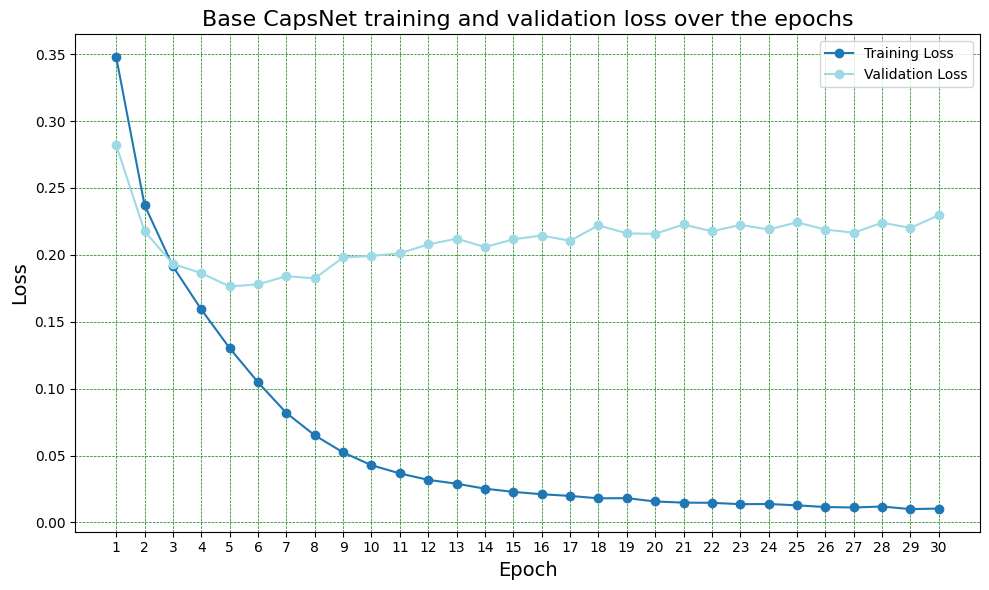

In [ ]:
utils.plot_line_chart(epoch_loss, ['Training Loss', 'Validation Loss'], 'Epoch', 'Loss',
                      'Base CapsNet training and validation loss over the epochs')

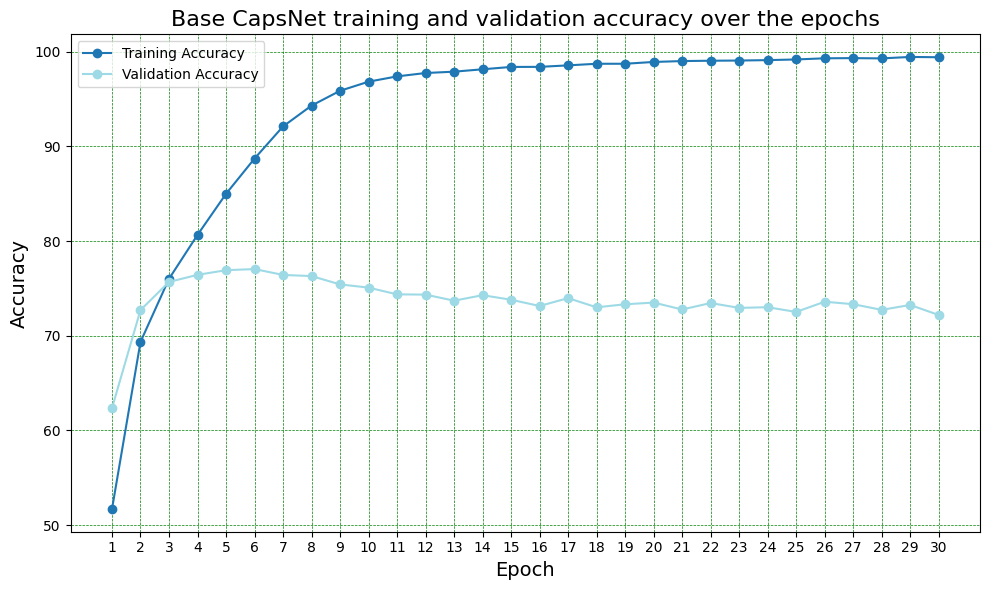

In [ ]:
utils.plot_line_chart(epoch_accuracy, ['Training Accuracy', 'Validation Accuracy'], 'Epoch', 'Accuracy',
                      'Base CapsNet training and validation accuracy over the epochs')

### Training with CCM loss

In [ ]:
CIFAR10_TRAIN_DIR = TRAIN_DIR+"cifar10/20Caps8Dim/"
batch_size=32
n_epochs=30
n_class=10

prim_caps_channels=20
prim_caps_dim=8
n_caps_layers=0

model_conv_config = {'in_img_h':32,
                     'in_img_w':32,
                     'in_img_c':3,
                     'kernel_size': [3, 3, 3, 3],
                     'stride': [1, 2, 1, 2],
                     'padding': [1, 1, 1, 0]}

train_loader, test_loader = image_dataloader(dataset='cifar10', batch_size=batch_size)

criterion = caps.CapsNetLoss(n_class=n_class)

Files already downloaded and verified
Files already downloaded and verified


In [ ]:
base_capsnet_cifar10_ccm_model = caps.CapsuleNetwork(in_img_c=3, in_img_h=32, in_img_w=32, n_class=n_class,
                                                 model_conv_config=model_conv_config, prim_caps_channels=prim_caps_channels,
                                                 prim_caps_dim=prim_caps_dim, n_caps_layers=n_caps_layers,
                                                 extract_feature_maps=True)

best_trained_base_capsnet_model = torch.load(CIFAR10_TRAIN_DIR+'Best_base_capsnet_cifar10_model.pt',
                                             map_location=device)

base_capsnet_cifar10_ccm_model.load_state_dict(best_trained_base_capsnet_model['model_state_dict'])

base_capsnet_cifar10_ccm_model.name = 'base_capsnet_cifar10_ccm_model'
base_capsnet_cifar10_ccm_model = base_capsnet_cifar10_ccm_model.to(device)
base_capsnet_cifar10_ccm_model.eval()

CapsuleNetwork(
  (conv_layer_1): ConvLayer(
    (conv_layer): Conv2d(3, 40, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(40, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv_layer_2): ConvLayer(
    (conv_layer): Conv2d(40, 80, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(80, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv_layer_3): ConvLayer(
    (conv_layer): Conv2d(80, 160, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(160, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (primary_caps): PrimaryCapsLayer(
    (primary_caps): Conv2d(160, 160, kernel_size=(3, 3), stride=(2, 2))
  )
  (class_caps): CapsLayer(
    (routing): RoutingByAggreement()
  )
)

In [ ]:
%%time
best_trained_ccm_model_path, _, _ = mtt.train_capsnet(n_epochs,
                                                      base_capsnet_cifar10_ccm_model,
                                                      criterion,
                                                      train_loader,
                                                      test_loader,
                                                      CIFAR10_TRAIN_DIR,
                                                      logger,
                                                      calc_ccm=True,
                                                      device=device)

02/03 03:41:32 AM | base_capsnet_cifar10_ccm_model Training - Epoch=1, Iteration=(0/1563), Loss=0.0527, Top 1 Acc=96.88, Top 5 Acc=96.88
INFO:capsnet:base_capsnet_cifar10_ccm_model Training - Epoch=1, Iteration=(0/1563), Loss=0.0527, Top 1 Acc=96.88, Top 5 Acc=96.88
02/03 03:41:34 AM | base_capsnet_cifar10_ccm_model Training - Epoch=1, Iteration=(32/1563), Loss=0.0655, Top 1 Acc=93.66, Top 5 Acc=99.81
INFO:capsnet:base_capsnet_cifar10_ccm_model Training - Epoch=1, Iteration=(32/1563), Loss=0.0655, Top 1 Acc=93.66, Top 5 Acc=99.81
02/03 03:41:37 AM | base_capsnet_cifar10_ccm_model Training - Epoch=1, Iteration=(64/1563), Loss=0.0616, Top 1 Acc=93.75, Top 5 Acc=99.86
INFO:capsnet:base_capsnet_cifar10_ccm_model Training - Epoch=1, Iteration=(64/1563), Loss=0.0616, Top 1 Acc=93.75, Top 5 Acc=99.86
02/03 03:41:39 AM | base_capsnet_cifar10_ccm_model Training - Epoch=1, Iteration=(96/1563), Loss=0.0598, Top 1 Acc=94.04, Top 5 Acc=99.81
INFO:capsnet:base_capsnet_cifar10_ccm_model Training - Ep

CPU times: user 57min 35s, sys: 3min 16s, total: 1h 51s
Wall time: 1h 44s


### CCM and CI score calculation

In [ ]:
CIFAR10_TRAIN_DIR = TRAIN_DIR+"cifar10/20Caps8Dim/"
batch_size=32
n_epochs=30
n_class=10

prim_caps_channels=20
prim_caps_dim=8
n_caps_layers=0

model_conv_config = {'in_img_h':32,
                     'in_img_w':32,
                     'in_img_c':3,
                     'kernel_size': [3, 3, 3, 3],
                     'stride': [1, 2, 1, 2],
                     'padding': [1, 1, 1, 0]}

train_loader, test_loader = image_dataloader(dataset='cifar10', batch_size=batch_size)

criterion = caps.CapsNetLoss(n_class=n_class)

Files already downloaded and verified
Files already downloaded and verified


In [ ]:
base_capsnet_cifar10_ccm_model = caps.CapsuleNetwork(in_img_c=3, in_img_h=32, in_img_w=32, n_class=n_class,
                                                     model_conv_config=model_conv_config, prim_caps_channels=prim_caps_channels,
                                                     prim_caps_dim=prim_caps_dim, n_caps_layers=n_caps_layers,
                                                     extract_feature_maps=True)

best_trained_base_capsnet_ccm_model = torch.load(CIFAR10_TRAIN_DIR+'Best_base_capsnet_cifar10_ccm_model.pt',
                                                 map_location=device)

base_capsnet_cifar10_ccm_model.load_state_dict(best_trained_base_capsnet_ccm_model['model_state_dict'])

base_capsnet_cifar10_ccm_model.name = 'base_capsnet_cifar10_ccm_model'
base_capsnet_cifar10_ccm_model = base_capsnet_cifar10_ccm_model.to(device)
base_capsnet_cifar10_ccm_model.eval()

CapsuleNetwork(
  (conv_layer_1): ConvLayer(
    (conv_layer): Conv2d(3, 40, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(40, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv_layer_2): ConvLayer(
    (conv_layer): Conv2d(40, 80, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(80, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv_layer_3): ConvLayer(
    (conv_layer): Conv2d(80, 160, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(160, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (primary_caps): PrimaryCapsLayer(
    (primary_caps): Conv2d(160, 160, kernel_size=(3, 3), stride=(2, 2))
  )
  (class_caps): CapsLayer(
    (routing): RoutingByAggreement()
  )
)

Extract Correlation Coefficient Matrix

In [ ]:
%%time
base_capsnet_cifar10_ccm_model.eval()

n_conv_layers = 4
layer_ccm_list = [ [] for _ in range(n_conv_layers) ]
layer_mean_ccm_list = []

with torch.no_grad():
    for images, _ in train_loader:
        images = images.to(device)

        _, _, batch_layer_feature_maps = base_capsnet_cifar10_ccm_model(images)

        for indx, batch_feature_maps in enumerate(batch_layer_feature_maps):
            _, batch_ccm = ccmp.calc_ccm_loss(batch_feature_maps)
            layer_ccm_list[indx].append(batch_ccm.detach().cpu())

        torch.cuda.empty_cache()

for i in range(n_conv_layers):
    layer_mean_ccm_list.append(torch.mean(torch.stack(layer_ccm_list[i]), dim=0))

ccmp.save_ccm(layer_mean_ccm_list, CIFAR10_TRAIN_DIR, base_capsnet_cifar10_ccm_model.name+'_ccm')

base_capsnet_cifar10_ccm_model_ccm saved
CPU times: user 27.8 s, sys: 4.07 s, total: 31.8 s
Wall time: 31.4 s


Channel Importance Scores

In [ ]:
%%time
base_capsnet_cifar10_ccm_model.eval()

n_conv_layers = 4
layer_ci_list = [ [] for _ in range(n_conv_layers) ]

with torch.no_grad():
    for images, _ in train_loader:
        images = images.to(device)

        _, _, batch_layer_feature_maps = base_capsnet_cifar10_ccm_model(images)

        for indx, batch_feature_maps in enumerate(batch_layer_feature_maps):
            batch_ci_score = ccmp.ci_score(batch_feature_maps)
            layer_ci_list[indx].append(batch_ci_score.detach().cpu().numpy())

        torch.cuda.empty_cache()

    layer_mean_ci_list = []

    for i in range(n_conv_layers):
        layer_mean_ci_list.append(np.mean(layer_ci_list[i], axis=0))

    np.save(CIFAR10_TRAIN_DIR+base_capsnet_cifar10_ccm_model.name+'_ci_scores.npy', np.asarray(layer_mean_ci_list, dtype=object))

CPU times: user 40min 5s, sys: 6.03 s, total: 40min 11s
Wall time: 40min 4s


### Pruning

In [ ]:
CIFAR10_TRAIN_DIR = TRAIN_DIR+"cifar10/20Caps8Dim/"
batch_size=64
n_epochs=30
n_class=10

prim_caps_channels=20
prim_caps_dim=8
n_caps_layers=0

model_conv_config = {'in_img_h': 32,
                     'in_img_w': 32,
                     'in_img_c': 3,
                     'kernel_size': [3, 3, 3, 3],
                     'stride': [1, 2, 1, 2],
                     'padding': [1, 1, 1, 0]}

train_loader, test_loader = image_dataloader(dataset='cifar10', batch_size=batch_size)

criterion = caps.CapsNetLoss(n_class=n_class)

Files already downloaded and verified
Files already downloaded and verified


In [ ]:
pretrained_base_capsnet_cifar10_ccm_model = caps.CapsuleNetwork(in_img_c=3, in_img_h=32, in_img_w=32, n_class=n_class,
                                                                model_conv_config=model_conv_config,
                                                                prim_caps_channels=prim_caps_channels,
                                                                prim_caps_dim=prim_caps_dim, n_caps_layers=n_caps_layers)

best_trained_base_capsnet_ccm_model = torch.load(CIFAR10_TRAIN_DIR+'Best_base_capsnet_cifar10_ccm_model.pt',
                                                 map_location=device)

pretrained_base_capsnet_cifar10_ccm_model.load_state_dict(best_trained_base_capsnet_ccm_model['model_state_dict'])

pretrained_base_capsnet_cifar10_ccm_model = pretrained_base_capsnet_cifar10_ccm_model.to(device)
pretrained_base_capsnet_cifar10_ccm_model.eval()

CapsuleNetwork(
  (conv_layer_1): ConvLayer(
    (conv_layer): Conv2d(3, 40, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(40, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv_layer_2): ConvLayer(
    (conv_layer): Conv2d(40, 80, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(80, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv_layer_3): ConvLayer(
    (conv_layer): Conv2d(80, 160, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(160, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (primary_caps): PrimaryCapsLayer(
    (primary_caps): Conv2d(160, 160, kernel_size=(3, 3), stride=(2, 2))
  )
  (class_caps): CapsLayer(
    (routing): RoutingByAggreement()
  )
)

In [ ]:
layers_to_prune_dict = {'conv_layer_1':0,
                        'conv_layer_2':1,
                        'conv_layer_3':2,
                        'primary_caps':3 }

base_capsnet_cifar10_ccm_model_ci_scores = np.load(CIFAR10_TRAIN_DIR+'base_capsnet_cifar10_ccm_model_ci_scores.npy', allow_pickle=True)
# base_capsnet_cifar10_ccm_model_ccm = ccmp.load_ccm(CIFAR10_TRAIN_DIR, 'base_capsnet_cifar10_ccm_model_ccm')

#### 12.5% Pruning

In [ ]:
prune_threshold = 0.125

channels_to_preserve = ccmp.get_channels_to_preserve(prune_threshold, base_capsnet_cifar10_ccm_model_ci_scores,
                                                     prim_caps_dim=prim_caps_dim, layers_to_prune=layers_to_prune_dict)

pruned_12pc_base_capsnet_cifar10_model = ccmp.prune_capsnet(pretrained_base_capsnet_cifar10_ccm_model,
                                                            model_conv_config_dict=model_conv_config, n_class=n_class,
                                                            n_caps_layers=n_caps_layers, prim_caps_dim=prim_caps_dim,
                                                            model_layers_to_prune=layers_to_prune_dict.keys(),
                                                            preserved_channels_dict=channels_to_preserve, device=device)

pruned_12pc_base_capsnet_cifar10_model.name = 'pruned_12pc_base_capsnet_cifar10_model'
pruned_12pc_base_capsnet_cifar10_model = pruned_12pc_base_capsnet_cifar10_model.to(device)

Pruned Model: CapsuleNetwork(
  (conv_layer_1): ConvLayer(
    (conv_layer): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv_layer_2): ConvLayer(
    (conv_layer): Conv2d(32, 72, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(72, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv_layer_3): ConvLayer(
    (conv_layer): Conv2d(72, 144, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(144, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (primary_caps): PrimaryCapsLayer(
    (primary_caps): Conv2d(144, 144, kernel_size=(3, 3), stride=(2, 2))
  )
  (class_caps): CapsLayer(
    (routing): RoutingByAggreement()
  )
)


##### Model Fine Tuning

In [ ]:
%%time
best_pruned_12pc_base_capsnet_path, _, _ = mtt.train_capsnet(n_epochs,
                                                             pruned_12pc_base_capsnet_cifar10_model,
                                                             criterion,
                                                             train_loader,
                                                             test_loader,
                                                             CIFAR10_TRAIN_DIR,
                                                             logger,
                                                             device=device)

02/05 02:29:28 AM | pruned_12pc_base_capsnet_cifar10_model Training - Epoch=1, Iteration=(0/782), Loss=1.9863, Top 1 Acc=10.94, Top 5 Acc=42.19
INFO:capsnet:pruned_12pc_base_capsnet_cifar10_model Training - Epoch=1, Iteration=(0/782), Loss=1.9863, Top 1 Acc=10.94, Top 5 Acc=42.19
02/05 02:29:34 AM | pruned_12pc_base_capsnet_cifar10_model Training - Epoch=1, Iteration=(64/782), Loss=0.6750, Top 1 Acc=23.80, Top 5 Acc=67.76
INFO:capsnet:pruned_12pc_base_capsnet_cifar10_model Training - Epoch=1, Iteration=(64/782), Loss=0.6750, Top 1 Acc=23.80, Top 5 Acc=67.76
02/05 02:29:39 AM | pruned_12pc_base_capsnet_cifar10_model Training - Epoch=1, Iteration=(128/782), Loss=0.5651, Top 1 Acc=29.76, Top 5 Acc=74.58
INFO:capsnet:pruned_12pc_base_capsnet_cifar10_model Training - Epoch=1, Iteration=(128/782), Loss=0.5651, Top 1 Acc=29.76, Top 5 Acc=74.58
02/05 02:29:44 AM | pruned_12pc_base_capsnet_cifar10_model Training - Epoch=1, Iteration=(192/782), Loss=0.5158, Top 1 Acc=33.62, Top 5 Acc=78.24
INFO:

CPU times: user 31min 46s, sys: 1min 34s, total: 33min 20s
Wall time: 33min 44s


##### Plots for losses and accuracies

In [ ]:
trained_pruned_12pc_base_capsnet_cifar10_model = torch.load(CIFAR10_TRAIN_DIR+'Trained_pruned_12pc_base_capsnet_cifar10_model_Epoch30_of_30.pt')

epoch_loss = trained_pruned_12pc_base_capsnet_cifar10_model['epoch_loss']
epoch_accuracy = trained_pruned_12pc_base_capsnet_cifar10_model['epoch_accuracy']

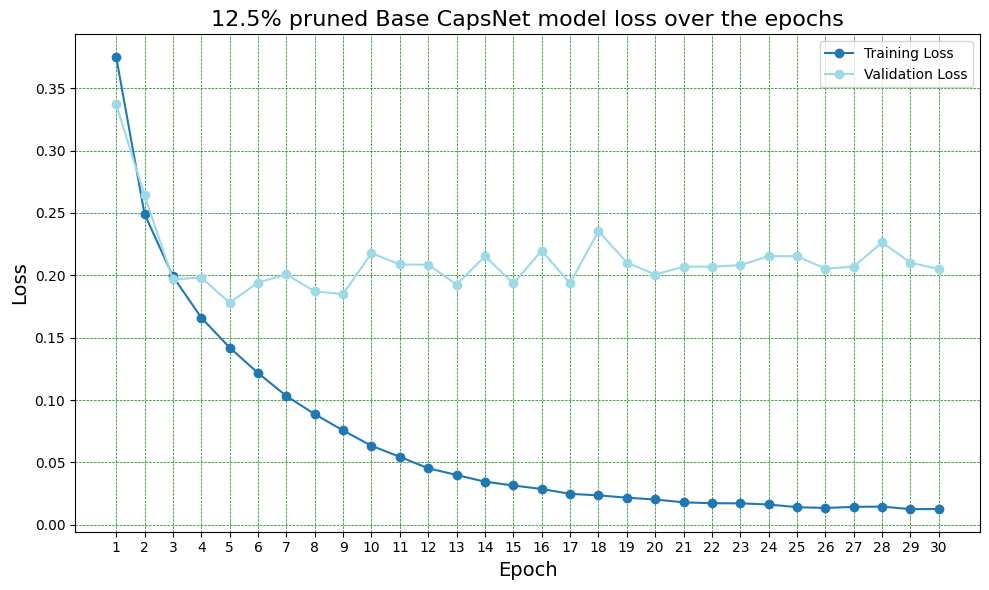

In [ ]:
utils.plot_line_chart(epoch_loss, ['Training Loss', 'Validation Loss'], 'Epoch', 'Loss',
                      '12.5% pruned Base CapsNet model loss over the epochs')

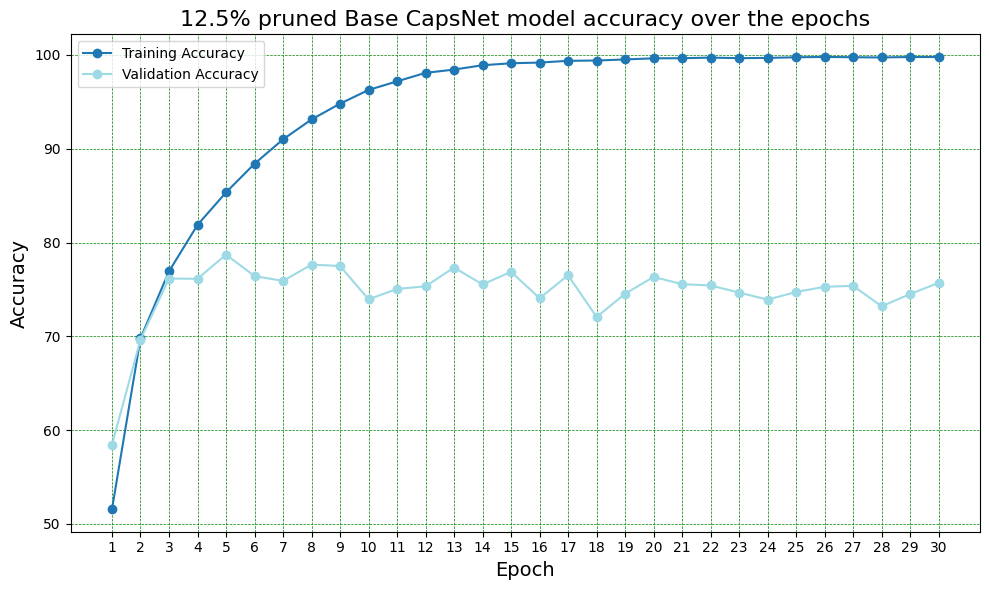

In [ ]:
utils.plot_line_chart(epoch_accuracy, ['Training Accuracy', 'Validation Accuracy'], 'Epoch', 'Accuracy',
                      '12.5% pruned Base CapsNet model accuracy over the epochs')

#### 25% Pruning

In [ ]:
prune_threshold = 0.25

channels_to_preserve = ccmp.get_channels_to_preserve(prune_threshold, base_capsnet_cifar10_ccm_model_ci_scores,
                                                     prim_caps_dim=prim_caps_dim, layers_to_prune=layers_to_prune_dict)

pruned_25pc_base_capsnet_cifar10_model = ccmp.prune_capsnet(pretrained_base_capsnet_cifar10_ccm_model,
                                                            model_conv_config_dict=model_conv_config, n_class=n_class,
                                                            n_caps_layers=n_caps_layers, prim_caps_dim=prim_caps_dim,
                                                            model_layers_to_prune=layers_to_prune_dict.keys(),
                                                            preserved_channels_dict=channels_to_preserve, device=device)

pruned_25pc_base_capsnet_cifar10_model.name = 'pruned_25pc_base_capsnet_cifar10_model'
pruned_25pc_base_capsnet_cifar10_model = pruned_25pc_base_capsnet_cifar10_model.to(device)

Pruned Model: CapsuleNetwork(
  (conv_layer_1): ConvLayer(
    (conv_layer): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv_layer_2): ConvLayer(
    (conv_layer): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv_layer_3): ConvLayer(
    (conv_layer): Conv2d(64, 120, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(120, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (primary_caps): PrimaryCapsLayer(
    (primary_caps): Conv2d(120, 120, kernel_size=(3, 3), stride=(2, 2))
  )
  (class_caps): CapsLayer(
    (routing): RoutingByAggreement()
  )
)


##### Model Fine Tuning

In [ ]:
%%time
best_pruned_25pc_base_capsnet_path, _, _ = mtt.train_capsnet(n_epochs,
                                                             pruned_25pc_base_capsnet_cifar10_model,
                                                             criterion,
                                                             train_loader,
                                                             test_loader,
                                                             CIFAR10_TRAIN_DIR,
                                                             logger,
                                                             device=device)

02/05 03:04:56 AM | pruned_25pc_base_capsnet_cifar10_model Training - Epoch=1, Iteration=(0/782), Loss=1.5768, Top 1 Acc=4.69, Top 5 Acc=43.75
INFO:capsnet:pruned_25pc_base_capsnet_cifar10_model Training - Epoch=1, Iteration=(0/782), Loss=1.5768, Top 1 Acc=4.69, Top 5 Acc=43.75
02/05 03:05:02 AM | pruned_25pc_base_capsnet_cifar10_model Training - Epoch=1, Iteration=(64/782), Loss=0.6182, Top 1 Acc=23.46, Top 5 Acc=69.18
INFO:capsnet:pruned_25pc_base_capsnet_cifar10_model Training - Epoch=1, Iteration=(64/782), Loss=0.6182, Top 1 Acc=23.46, Top 5 Acc=69.18
02/05 03:05:06 AM | pruned_25pc_base_capsnet_cifar10_model Training - Epoch=1, Iteration=(128/782), Loss=0.5231, Top 1 Acc=32.05, Top 5 Acc=76.19
INFO:capsnet:pruned_25pc_base_capsnet_cifar10_model Training - Epoch=1, Iteration=(128/782), Loss=0.5231, Top 1 Acc=32.05, Top 5 Acc=76.19
02/05 03:05:12 AM | pruned_25pc_base_capsnet_cifar10_model Training - Epoch=1, Iteration=(192/782), Loss=0.4757, Top 1 Acc=37.61, Top 5 Acc=80.21
INFO:ca

CPU times: user 30min 37s, sys: 1min 33s, total: 32min 11s
Wall time: 32min 34s


##### Plots for losses and accuracies

In [ ]:
trained_pruned_25pc_base_capsnet_cifar10_model = torch.load(CIFAR10_TRAIN_DIR+'Trained_pruned_25pc_base_capsnet_cifar10_model_Epoch30_of_30.pt')

epoch_loss = trained_pruned_25pc_base_capsnet_cifar10_model['epoch_loss']
epoch_accuracy = trained_pruned_25pc_base_capsnet_cifar10_model['epoch_accuracy']

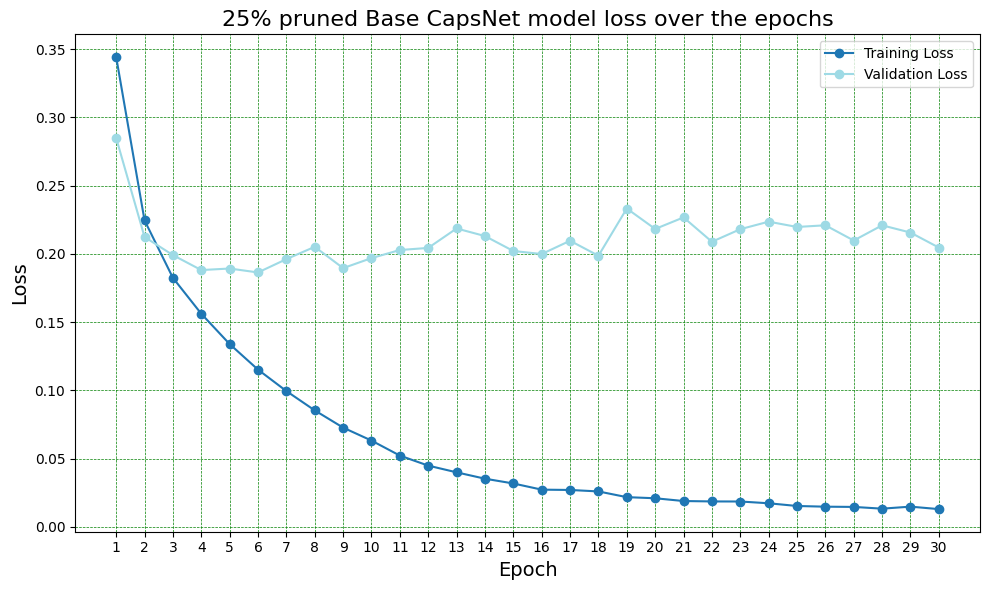

In [ ]:
utils.plot_line_chart(epoch_loss, ['Training Loss', 'Validation Loss'], 'Epoch', 'Loss',
                      '25% pruned Base CapsNet model loss over the epochs')

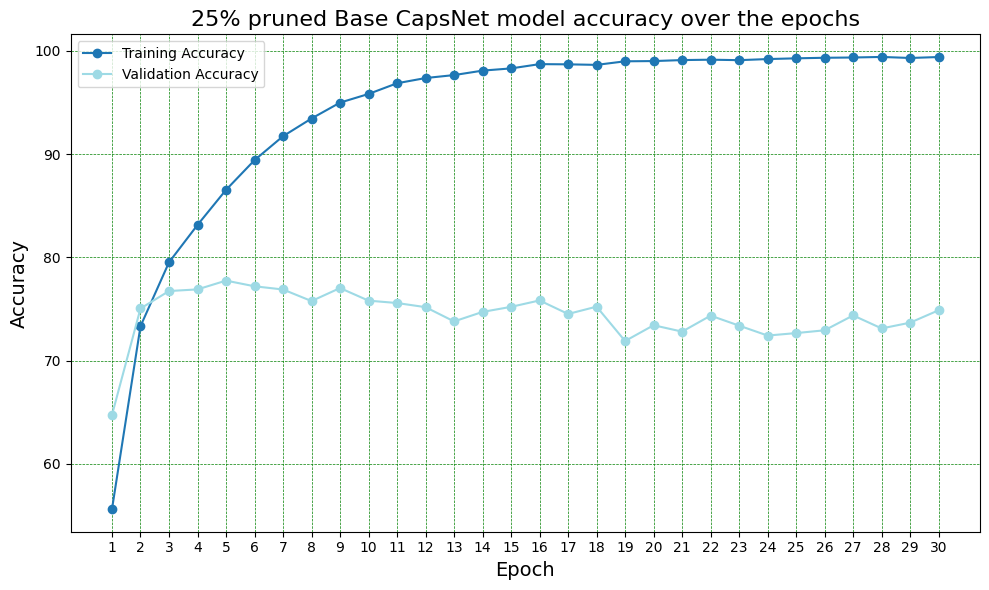

In [ ]:
utils.plot_line_chart(epoch_accuracy, ['Training Accuracy', 'Validation Accuracy'], 'Epoch', 'Accuracy',
                      '25% pruned Base CapsNet model accuracy over the epochs')

#### 37.5% Pruning

In [ ]:
prune_threshold = 0.375

channels_to_preserve = ccmp.get_channels_to_preserve(prune_threshold, base_capsnet_cifar10_ccm_model_ci_scores,
                                                     prim_caps_dim=prim_caps_dim, layers_to_prune=layers_to_prune_dict)

pruned_37pc_base_capsnet_cifar10_model = ccmp.prune_capsnet(pretrained_base_capsnet_cifar10_ccm_model,
                                                            model_conv_config_dict=model_conv_config, n_class=n_class,
                                                            n_caps_layers=n_caps_layers, prim_caps_dim=prim_caps_dim,
                                                            model_layers_to_prune=layers_to_prune_dict.keys(),
                                                            preserved_channels_dict=channels_to_preserve, device=device)

pruned_37pc_base_capsnet_cifar10_model.name = 'pruned_37pc_base_capsnet_cifar10_model'
pruned_37pc_base_capsnet_cifar10_model = pruned_37pc_base_capsnet_cifar10_model.to(device)

Pruned Model: CapsuleNetwork(
  (conv_layer_1): ConvLayer(
    (conv_layer): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv_layer_2): ConvLayer(
    (conv_layer): Conv2d(32, 56, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(56, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv_layer_3): ConvLayer(
    (conv_layer): Conv2d(56, 104, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(104, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (primary_caps): PrimaryCapsLayer(
    (primary_caps): Conv2d(104, 104, kernel_size=(3, 3), stride=(2, 2))
  )
  (class_caps): CapsLayer(
    (routing): RoutingByAggreement()
  )
)


##### Model Fine Tuning

In [ ]:
%%time
best_pruned_37pc_base_capsnet_path, _, _ = mtt.train_capsnet(n_epochs,
                                                             pruned_37pc_base_capsnet_cifar10_model,
                                                             criterion,
                                                             train_loader,
                                                             test_loader,
                                                             CIFAR10_TRAIN_DIR,
                                                             logger,
                                                             device=device)

02/05 03:40:40 AM | pruned_37pc_base_capsnet_cifar10_model Training - Epoch=1, Iteration=(0/782), Loss=1.3593, Top 1 Acc=9.38, Top 5 Acc=53.12
INFO:capsnet:pruned_37pc_base_capsnet_cifar10_model Training - Epoch=1, Iteration=(0/782), Loss=1.3593, Top 1 Acc=9.38, Top 5 Acc=53.12
02/05 03:40:46 AM | pruned_37pc_base_capsnet_cifar10_model Training - Epoch=1, Iteration=(64/782), Loss=0.5762, Top 1 Acc=25.43, Top 5 Acc=71.06
INFO:capsnet:pruned_37pc_base_capsnet_cifar10_model Training - Epoch=1, Iteration=(64/782), Loss=0.5762, Top 1 Acc=25.43, Top 5 Acc=71.06
02/05 03:40:51 AM | pruned_37pc_base_capsnet_cifar10_model Training - Epoch=1, Iteration=(128/782), Loss=0.4886, Top 1 Acc=34.80, Top 5 Acc=78.83
INFO:capsnet:pruned_37pc_base_capsnet_cifar10_model Training - Epoch=1, Iteration=(128/782), Loss=0.4886, Top 1 Acc=34.80, Top 5 Acc=78.83
02/05 03:40:55 AM | pruned_37pc_base_capsnet_cifar10_model Training - Epoch=1, Iteration=(192/782), Loss=0.4502, Top 1 Acc=39.64, Top 5 Acc=82.25
INFO:ca

CPU times: user 30min 43s, sys: 1min 33s, total: 32min 16s
Wall time: 32min 35s


##### Plots for losses and accuracies

In [ ]:
trained_pruned_37pc_base_capsnet_cifar10_model = torch.load(CIFAR10_TRAIN_DIR+'Trained_pruned_37pc_base_capsnet_cifar10_model_Epoch30_of_30.pt')

epoch_loss = trained_pruned_37pc_base_capsnet_cifar10_model['epoch_loss']
epoch_accuracy = trained_pruned_37pc_base_capsnet_cifar10_model['epoch_accuracy']

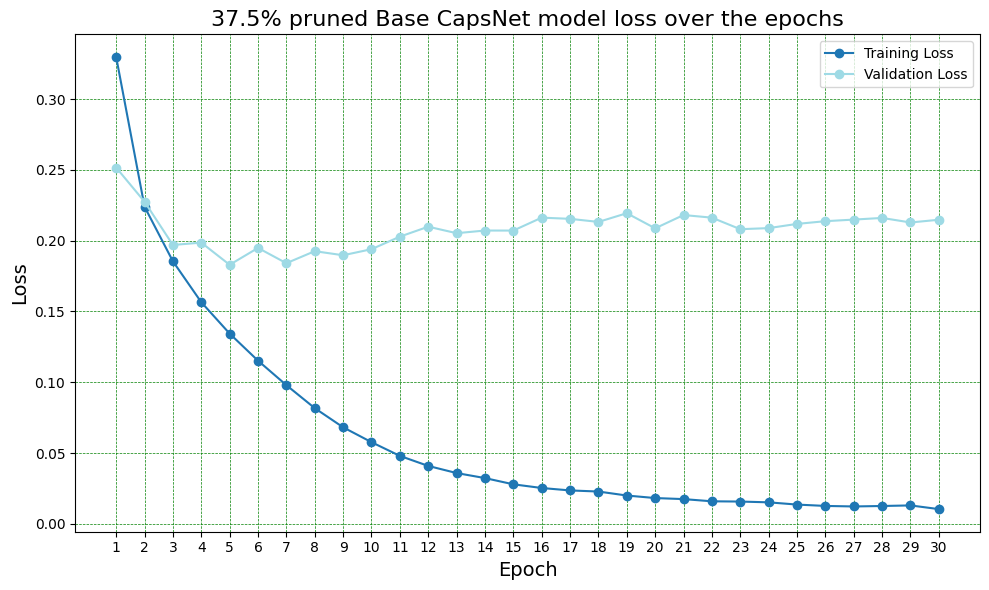

In [ ]:
utils.plot_line_chart(epoch_loss, ['Training Loss', 'Validation Loss'], 'Epoch', 'Loss',
                      '37.5% pruned Base CapsNet model loss over the epochs')

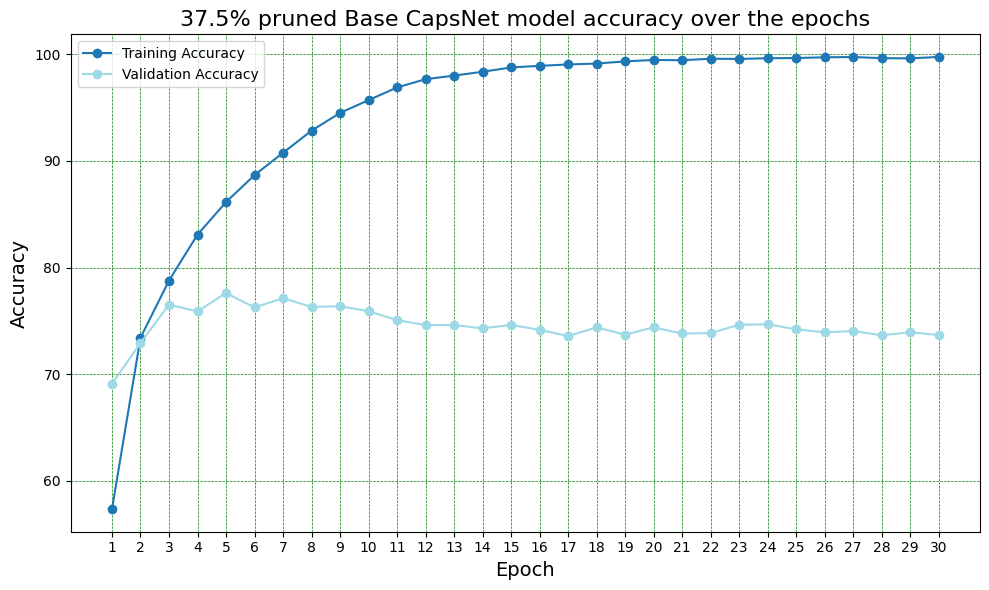

In [ ]:
utils.plot_line_chart(epoch_accuracy, ['Training Accuracy', 'Validation Accuracy'], 'Epoch', 'Accuracy',
                      '37.5% pruned Base CapsNet model accuracy over the epochs')

#### 50% Pruning

In [ ]:
prune_threshold = 0.50

channels_to_preserve = ccmp.get_channels_to_preserve(prune_threshold, base_capsnet_cifar10_ccm_model_ci_scores,
                                                     prim_caps_dim=prim_caps_dim, layers_to_prune=layers_to_prune_dict)

pruned_50pc_base_capsnet_cifar10_model = ccmp.prune_capsnet(pretrained_base_capsnet_cifar10_ccm_model,
                                                            model_conv_config_dict=model_conv_config, n_class=n_class,
                                                            n_caps_layers=n_caps_layers, prim_caps_dim=prim_caps_dim,
                                                            model_layers_to_prune=layers_to_prune_dict.keys(),
                                                            preserved_channels_dict=channels_to_preserve, device=device)

pruned_50pc_base_capsnet_cifar10_model.name = 'pruned_50pc_base_capsnet_cifar10_model'
pruned_50pc_base_capsnet_cifar10_model = pruned_50pc_base_capsnet_cifar10_model.to(device)

Pruned Model: CapsuleNetwork(
  (conv_layer_1): ConvLayer(
    (conv_layer): Conv2d(3, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv_layer_2): ConvLayer(
    (conv_layer): Conv2d(24, 40, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(40, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv_layer_3): ConvLayer(
    (conv_layer): Conv2d(40, 80, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(80, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (primary_caps): PrimaryCapsLayer(
    (primary_caps): Conv2d(80, 80, kernel_size=(3, 3), stride=(2, 2))
  )
  (class_caps): CapsLayer(
    (routing): RoutingByAggreement()
  )
)


##### Model Fine Tuning

In [ ]:
%%time
best_pruned_50pc_base_capsnet_path, _, _ = mtt.train_capsnet(n_epochs,
                                                             pruned_50pc_base_capsnet_cifar10_model,
                                                             criterion,
                                                             train_loader,
                                                             test_loader,
                                                             CIFAR10_TRAIN_DIR,
                                                             logger,
                                                             device=device)

02/05 04:17:25 AM | pruned_50pc_base_capsnet_cifar10_model Training - Epoch=1, Iteration=(0/782), Loss=1.0164, Top 1 Acc=10.94, Top 5 Acc=43.75
INFO:capsnet:pruned_50pc_base_capsnet_cifar10_model Training - Epoch=1, Iteration=(0/782), Loss=1.0164, Top 1 Acc=10.94, Top 5 Acc=43.75
02/05 04:17:30 AM | pruned_50pc_base_capsnet_cifar10_model Training - Epoch=1, Iteration=(64/782), Loss=0.5116, Top 1 Acc=30.46, Top 5 Acc=73.22
INFO:capsnet:pruned_50pc_base_capsnet_cifar10_model Training - Epoch=1, Iteration=(64/782), Loss=0.5116, Top 1 Acc=30.46, Top 5 Acc=73.22
02/05 04:17:35 AM | pruned_50pc_base_capsnet_cifar10_model Training - Epoch=1, Iteration=(128/782), Loss=0.4456, Top 1 Acc=40.43, Top 5 Acc=80.97
INFO:capsnet:pruned_50pc_base_capsnet_cifar10_model Training - Epoch=1, Iteration=(128/782), Loss=0.4456, Top 1 Acc=40.43, Top 5 Acc=80.97
02/05 04:17:39 AM | pruned_50pc_base_capsnet_cifar10_model Training - Epoch=1, Iteration=(192/782), Loss=0.4094, Top 1 Acc=45.68, Top 5 Acc=84.56
INFO:

CPU times: user 30min 33s, sys: 1min 33s, total: 32min 6s
Wall time: 32min 23s


##### Plots for losses and accuracies

In [ ]:
trained_pruned_50pc_base_capsnet_cifar10_model = torch.load(CIFAR10_TRAIN_DIR+'Trained_pruned_50pc_base_capsnet_cifar10_model_Epoch30_of_30.pt')

epoch_loss = trained_pruned_50pc_base_capsnet_cifar10_model['epoch_loss']
epoch_accuracy = trained_pruned_50pc_base_capsnet_cifar10_model['epoch_accuracy']

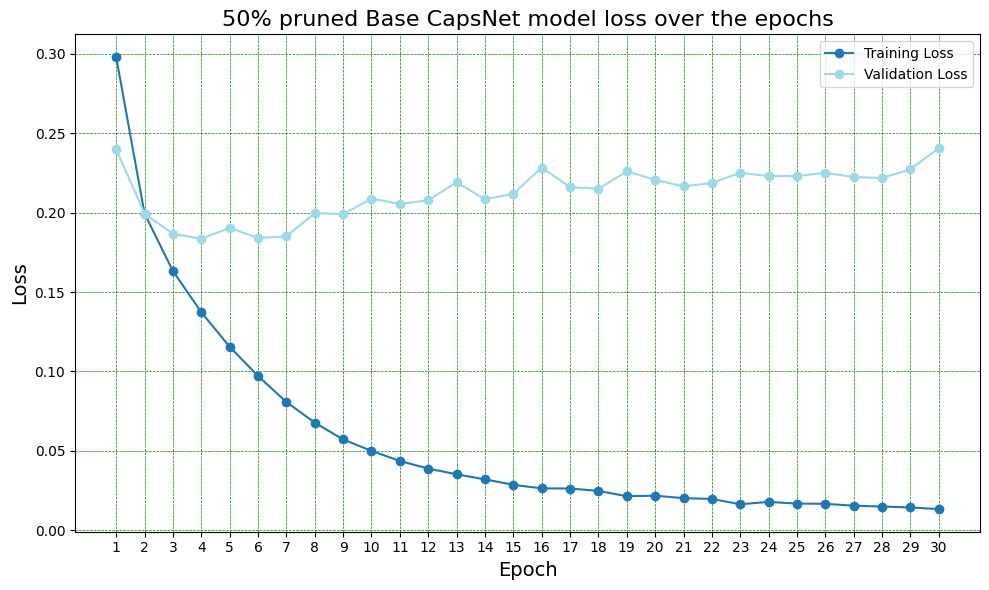

In [ ]:
utils.plot_line_chart(epoch_loss, ['Training Loss', 'Validation Loss'], 'Epoch', 'Loss',
                      '50% pruned Base CapsNet model loss over the epochs')

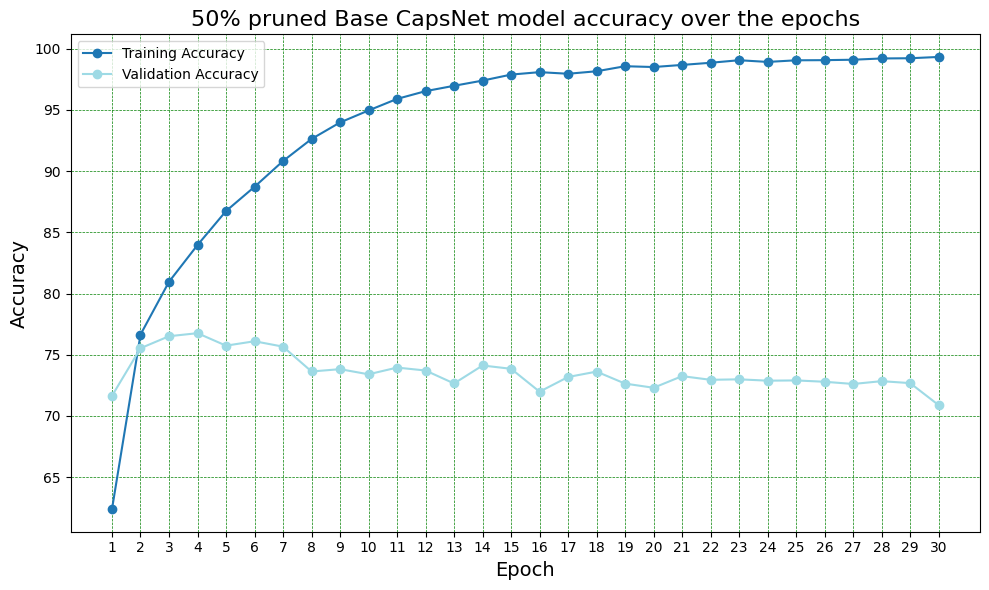

In [ ]:
utils.plot_line_chart(epoch_accuracy, ['Training Accuracy', 'Validation Accuracy'], 'Epoch', 'Accuracy',
                      '50% pruned Base CapsNet model accuracy over the epochs')

#### 60% Pruning

In [ ]:
prune_threshold = 0.60

channels_to_preserve = ccmp.get_channels_to_preserve(prune_threshold, base_capsnet_cifar10_ccm_model_ci_scores,
                                                     prim_caps_dim=prim_caps_dim, layers_to_prune=layers_to_prune_dict)

pruned_60pc_base_capsnet_cifar10_model = ccmp.prune_capsnet(pretrained_base_capsnet_cifar10_ccm_model,
                                                            model_conv_config_dict=model_conv_config, n_class=n_class,
                                                            n_caps_layers=n_caps_layers, prim_caps_dim=prim_caps_dim,
                                                            model_layers_to_prune=layers_to_prune_dict.keys(),
                                                            preserved_channels_dict=channels_to_preserve, device=device)

pruned_60pc_base_capsnet_cifar10_model.name = 'pruned_60pc_base_capsnet_cifar10_model'
pruned_60pc_base_capsnet_cifar10_model = pruned_60pc_base_capsnet_cifar10_model.to(device)

Pruned Model: CapsuleNetwork(
  (conv_layer_1): ConvLayer(
    (conv_layer): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv_layer_2): ConvLayer(
    (conv_layer): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv_layer_3): ConvLayer(
    (conv_layer): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (primary_caps): PrimaryCapsLayer(
    (primary_caps): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2))
  )
  (class_caps): CapsLayer(
    (routing): RoutingByAggreement()
  )
)


##### Model Fine Tuning

In [ ]:
%%time
best_pruned_60pc_base_capsnet_path, _, _ = mtt.train_capsnet(n_epochs,
                                                             pruned_60pc_base_capsnet_cifar10_model,
                                                             criterion,
                                                             train_loader,
                                                             test_loader,
                                                             CIFAR10_TRAIN_DIR,
                                                             logger,
                                                             device=device)

02/05 04:51:03 AM | pruned_60pc_base_capsnet_cifar10_model Training - Epoch=1, Iteration=(0/782), Loss=0.7093, Top 1 Acc=0.00, Top 5 Acc=39.06
INFO:capsnet:pruned_60pc_base_capsnet_cifar10_model Training - Epoch=1, Iteration=(0/782), Loss=0.7093, Top 1 Acc=0.00, Top 5 Acc=39.06
02/05 04:51:09 AM | pruned_60pc_base_capsnet_cifar10_model Training - Epoch=1, Iteration=(64/782), Loss=0.4546, Top 1 Acc=35.75, Top 5 Acc=79.45
INFO:capsnet:pruned_60pc_base_capsnet_cifar10_model Training - Epoch=1, Iteration=(64/782), Loss=0.4546, Top 1 Acc=35.75, Top 5 Acc=79.45
02/05 04:51:13 AM | pruned_60pc_base_capsnet_cifar10_model Training - Epoch=1, Iteration=(128/782), Loss=0.4065, Top 1 Acc=44.51, Top 5 Acc=85.05
INFO:capsnet:pruned_60pc_base_capsnet_cifar10_model Training - Epoch=1, Iteration=(128/782), Loss=0.4065, Top 1 Acc=44.51, Top 5 Acc=85.05
02/05 04:51:18 AM | pruned_60pc_base_capsnet_cifar10_model Training - Epoch=1, Iteration=(192/782), Loss=0.3764, Top 1 Acc=49.30, Top 5 Acc=87.90
INFO:ca

CPU times: user 29min 9s, sys: 1min 32s, total: 30min 42s
Wall time: 31min


#####Plots for losses and accuracies

In [ ]:
trained_pruned_60pc_base_capsnet_cifar10_model = torch.load(CIFAR10_TRAIN_DIR+'Trained_pruned_60pc_base_capsnet_cifar10_model_Epoch30_of_30.pt')

epoch_loss = trained_pruned_60pc_base_capsnet_cifar10_model['epoch_loss']
epoch_accuracy = trained_pruned_60pc_base_capsnet_cifar10_model['epoch_accuracy']

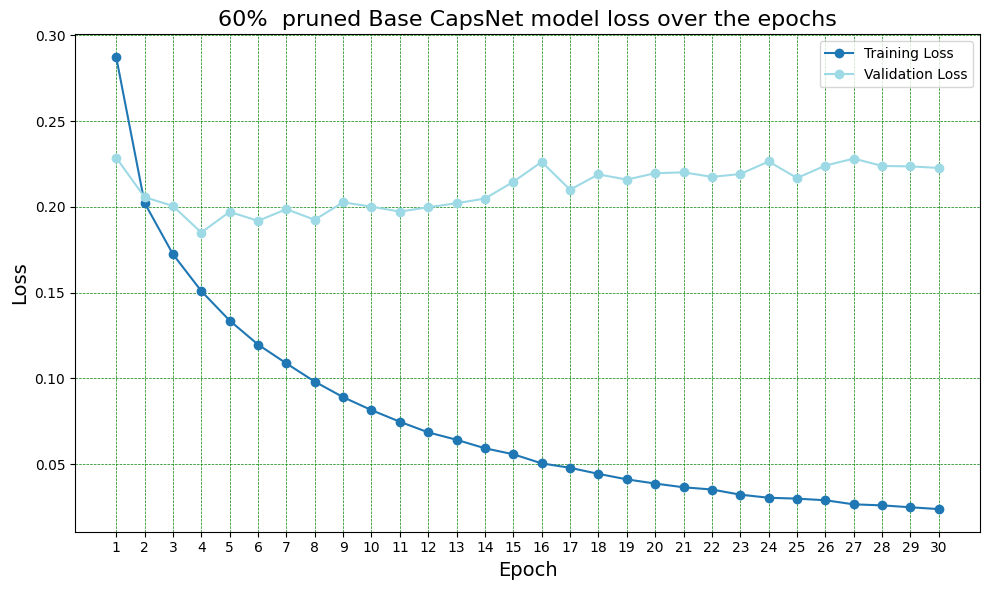

In [ ]:
utils.plot_line_chart(epoch_loss, ['Training Loss', 'Validation Loss'], 'Epoch', 'Loss',
                      '60% pruned Base CapsNet model loss over the epochs')

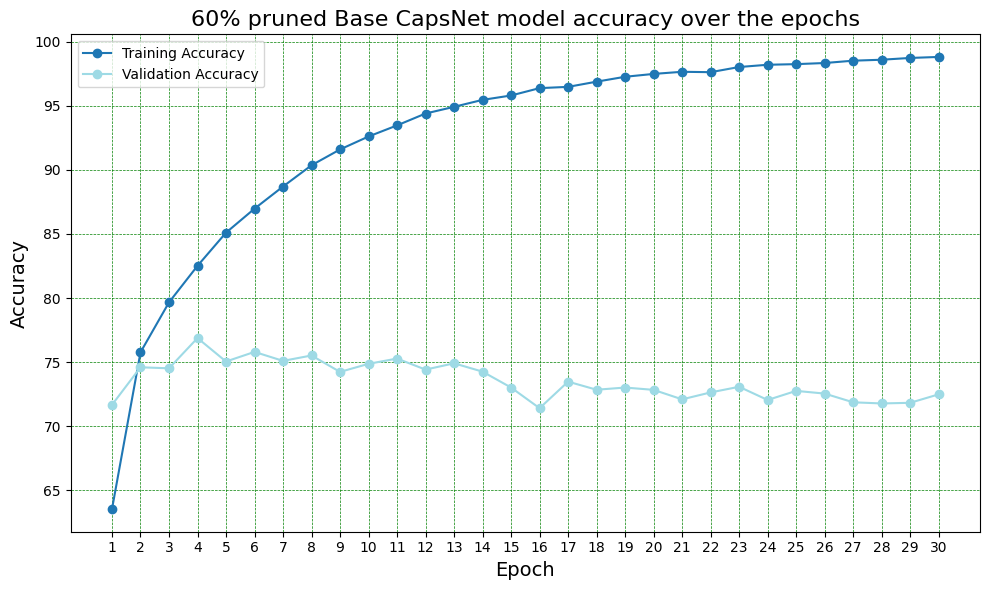

In [ ]:
utils.plot_line_chart(epoch_accuracy, ['Training Accuracy', 'Validation Accuracy'], 'Epoch', 'Accuracy',
                      '60% pruned Base CapsNet model accuracy over the epochs')

#### 75% Pruning

In [ ]:
prune_threshold = 0.75

channels_to_preserve = ccmp.get_channels_to_preserve(prune_threshold, base_capsnet_cifar10_ccm_model_ci_scores,
                                                     prim_caps_dim=prim_caps_dim, layers_to_prune=layers_to_prune_dict)

pruned_75pc_base_capsnet_cifar10_model = ccmp.prune_capsnet(pretrained_base_capsnet_cifar10_ccm_model,
                                                            model_conv_config_dict=model_conv_config, n_class=n_class,
                                                            n_caps_layers=n_caps_layers, prim_caps_dim=prim_caps_dim,
                                                            model_layers_to_prune=layers_to_prune_dict.keys(),
                                                            preserved_channels_dict=channels_to_preserve, device=device)

pruned_75pc_base_capsnet_cifar10_model.name = 'pruned_75pc_base_capsnet_cifar10_model'
pruned_75pc_base_capsnet_cifar10_model = pruned_75pc_base_capsnet_cifar10_model.to(device)

Pruned Model: CapsuleNetwork(
  (conv_layer_1): ConvLayer(
    (conv_layer): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv_layer_2): ConvLayer(
    (conv_layer): Conv2d(16, 24, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv_layer_3): ConvLayer(
    (conv_layer): Conv2d(24, 40, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(40, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (primary_caps): PrimaryCapsLayer(
    (primary_caps): Conv2d(40, 40, kernel_size=(3, 3), stride=(2, 2))
  )
  (class_caps): CapsLayer(
    (routing): RoutingByAggreement()
  )
)


##### Model Fine Tuning

In [ ]:
%%time
best_pruned_75pc_base_capsnet_path, _, _ = mtt.train_capsnet(n_epochs,
                                                             pruned_75pc_base_capsnet_cifar10_model,
                                                             criterion,
                                                             train_loader,
                                                             test_loader,
                                                             CIFAR10_TRAIN_DIR,
                                                             logger,
                                                             device=device)

02/05 05:24:51 AM | pruned_75pc_base_capsnet_cifar10_model Training - Epoch=1, Iteration=(0/782), Loss=0.5533, Top 1 Acc=7.81, Top 5 Acc=53.12
INFO:capsnet:pruned_75pc_base_capsnet_cifar10_model Training - Epoch=1, Iteration=(0/782), Loss=0.5533, Top 1 Acc=7.81, Top 5 Acc=53.12
02/05 05:24:55 AM | pruned_75pc_base_capsnet_cifar10_model Training - Epoch=1, Iteration=(64/782), Loss=0.4262, Top 1 Acc=37.40, Top 5 Acc=83.56
INFO:capsnet:pruned_75pc_base_capsnet_cifar10_model Training - Epoch=1, Iteration=(64/782), Loss=0.4262, Top 1 Acc=37.40, Top 5 Acc=83.56
02/05 05:25:01 AM | pruned_75pc_base_capsnet_cifar10_model Training - Epoch=1, Iteration=(128/782), Loss=0.3827, Top 1 Acc=46.20, Top 5 Acc=88.13
INFO:capsnet:pruned_75pc_base_capsnet_cifar10_model Training - Epoch=1, Iteration=(128/782), Loss=0.3827, Top 1 Acc=46.20, Top 5 Acc=88.13
02/05 05:25:05 AM | pruned_75pc_base_capsnet_cifar10_model Training - Epoch=1, Iteration=(192/782), Loss=0.3573, Top 1 Acc=50.99, Top 5 Acc=90.11
INFO:ca

CPU times: user 27min 20s, sys: 1min 34s, total: 28min 54s
Wall time: 29min 19s


#####Plots for losses and accuracies

In [ ]:
trained_pruned_75pc_base_capsnet_cifar10_model = torch.load(CIFAR10_TRAIN_DIR+'Trained_pruned_75pc_base_capsnet_cifar10_model_Epoch30_of_30.pt')

epoch_loss = trained_pruned_75pc_base_capsnet_cifar10_model['epoch_loss']
epoch_accuracy = trained_pruned_75pc_base_capsnet_cifar10_model['epoch_accuracy']

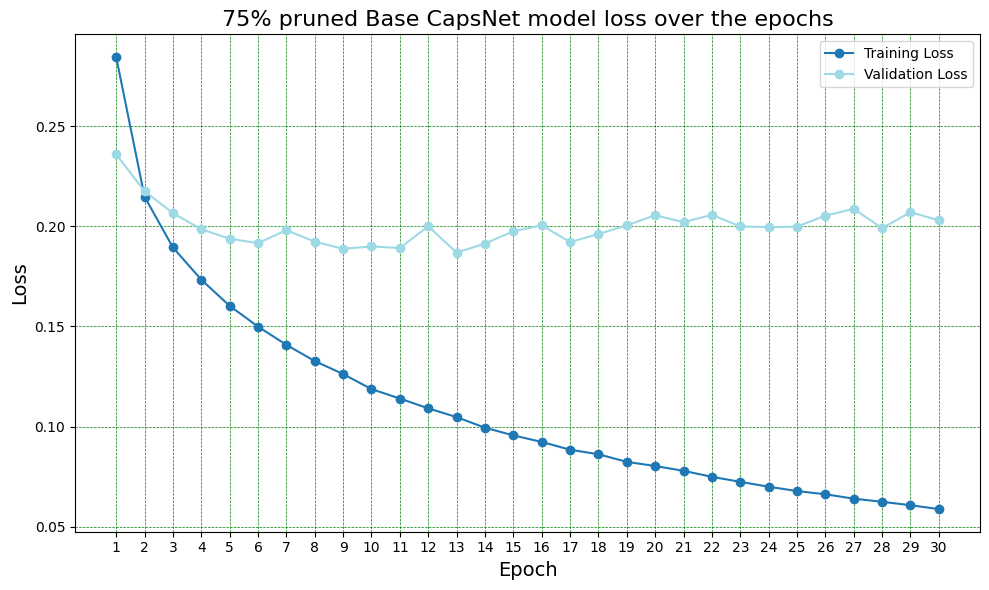

In [ ]:
utils.plot_line_chart(epoch_loss, ['Training Loss', 'Validation Loss'], 'Epoch', 'Loss',
                      '75% pruned Base CapsNet model loss over the epochs')

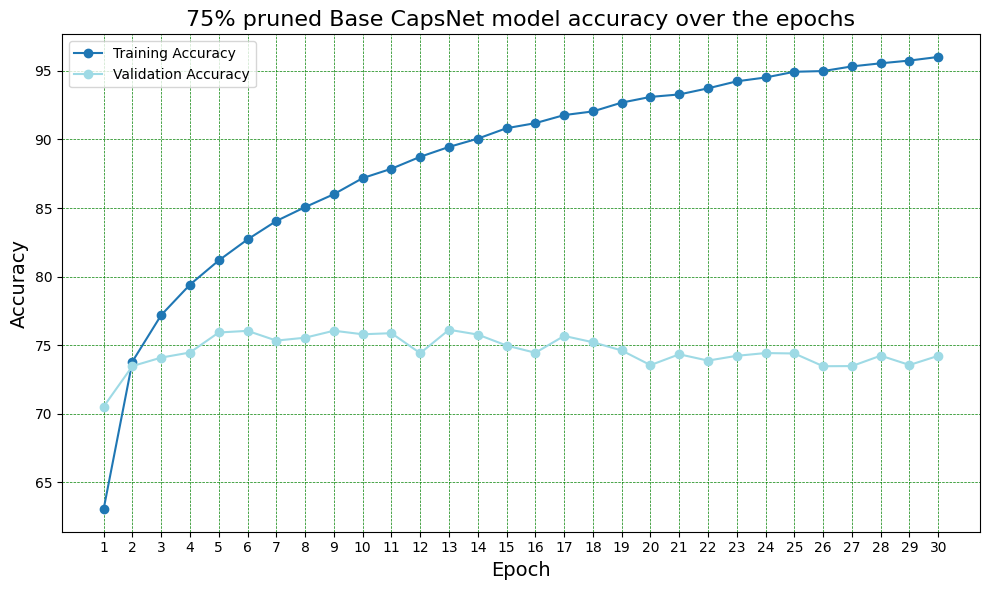

In [ ]:
utils.plot_line_chart(epoch_accuracy, ['Training Accuracy', 'Validation Accuracy'], 'Epoch', 'Accuracy',
                      '75% pruned Base CapsNet model accuracy over the epochs')

#### Plots for Unpruned and Pruned CapsNet

In [ ]:
trained_base_capsnet_cifar10_model = torch.load(CIFAR10_TRAIN_DIR+'Trained_base_capsnet_cifar10_model_Epoch30_of_30.pt')
trained_pruned_12pc_base_capsnet_cifar10_model = torch.load(CIFAR10_TRAIN_DIR+'Trained_pruned_12pc_base_capsnet_cifar10_model_Epoch30_of_30.pt')
trained_pruned_25pc_base_capsnet_cifar10_model = torch.load(CIFAR10_TRAIN_DIR+'Trained_pruned_25pc_base_capsnet_cifar10_model_Epoch30_of_30.pt')
trained_pruned_37pc_base_capsnet_cifar10_model = torch.load(CIFAR10_TRAIN_DIR+'Trained_pruned_37pc_base_capsnet_cifar10_model_Epoch30_of_30.pt')
trained_pruned_50pc_base_capsnet_cifar10_model = torch.load(CIFAR10_TRAIN_DIR+'Trained_pruned_50pc_base_capsnet_cifar10_model_Epoch30_of_30.pt')
trained_pruned_60pc_base_capsnet_cifar10_model = torch.load(CIFAR10_TRAIN_DIR+'Trained_pruned_60pc_base_capsnet_cifar10_model_Epoch30_of_30.pt')
trained_pruned_75pc_base_capsnet_cifar10_model = torch.load(CIFAR10_TRAIN_DIR+'Trained_pruned_75pc_base_capsnet_cifar10_model_Epoch30_of_30.pt')

models = [trained_base_capsnet_cifar10_model,
          trained_pruned_12pc_base_capsnet_cifar10_model,
          trained_pruned_25pc_base_capsnet_cifar10_model,
          trained_pruned_37pc_base_capsnet_cifar10_model,
          trained_pruned_50pc_base_capsnet_cifar10_model,
          trained_pruned_60pc_base_capsnet_cifar10_model,
          trained_pruned_75pc_base_capsnet_cifar10_model]

n_epochs = 30

epoch_losses = np.zeros((len(models), n_epochs))
epoch_accuracies = np.zeros((len(models), n_epochs))

for indx, model in enumerate(models):
    epoch_losses[indx] = model['epoch_loss'][1]
    epoch_accuracies[indx] = model['epoch_accuracy'][1]

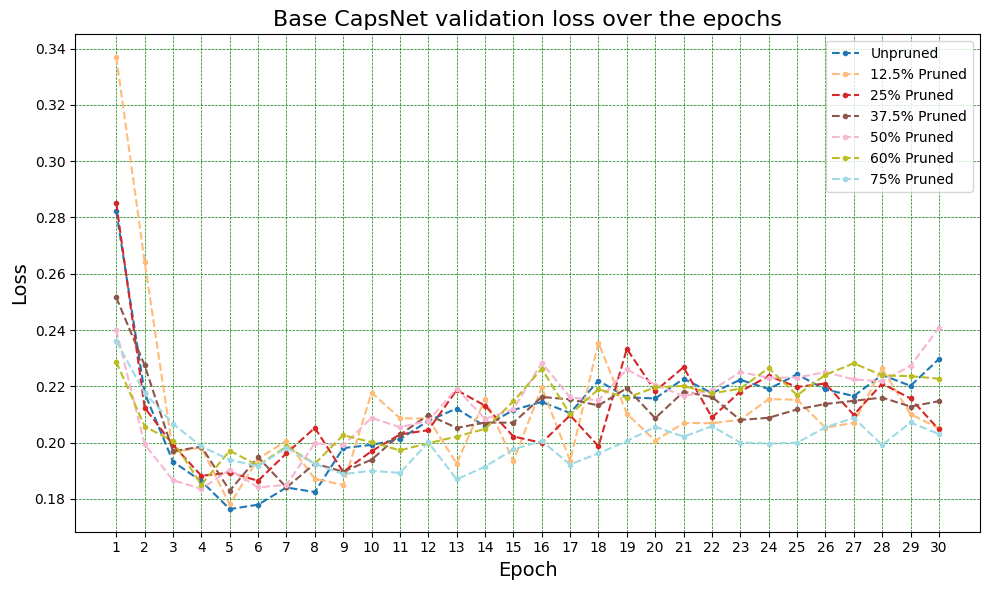

In [ ]:
utils.plot_line_chart(epoch_losses, ['Unpruned', '12.5% Pruned', '25% Pruned', '37.5% Pruned', '50% Pruned', '60% Pruned', '75% Pruned'],
                      'Epoch', 'Loss', 'Base CapsNet validation loss over the epochs', marker='.', line='--')

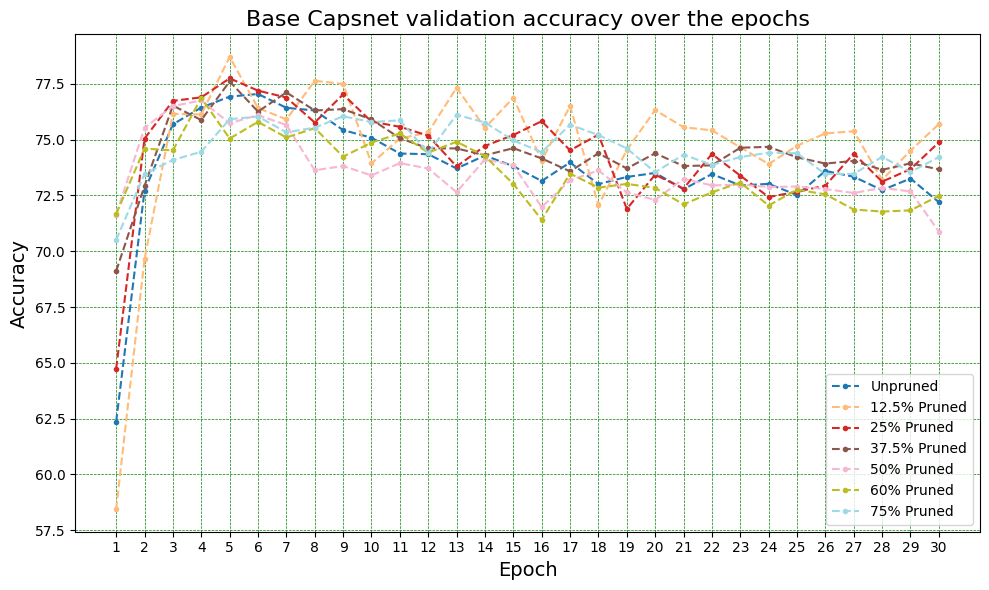

In [ ]:
utils.plot_line_chart(epoch_accuracies, ['Unpruned', '12.5% Pruned', '25% Pruned', '37.5% Pruned', '50% Pruned', '60% Pruned', '75% Pruned'],
                      'Epoch', 'Accuracy', 'Base Capsnet validation accuracy over the epochs', marker='.', line='--')

#### Flops and Params Count

In [ ]:
input_cifar10_image_size = torch.randn(1, 3, 32, 32).to(device)

In [ ]:
base_capsnet_cifar10_model.eval()

flops, params = profile(base_capsnet_cifar10_model, inputs=(input_cifar10_image_size,))

print("{} CIFAR10 Flops = {}".format(base_capsnet_cifar10_model.name, flops))
print("{} CIFAR10 Params = {}".format(base_capsnet_cifar10_model.name, params))

[INFO] Register count_convNd() for <class 'torch.nn.modules.conv.Conv2d'>.
[INFO] Register count_normalization() for <class 'torch.nn.modules.batchnorm.BatchNorm2d'>.
base_capsnet_cifar10_model CIFAR10 Flops = 49669120.0
base_capsnet_cifar10_model CIFAR10 Params = 376200.0


In [ ]:
prune_threshold = 0.125
pruned_12pc_base_capsnet_cifar10_model.eval()

flops, params = profile(pruned_12pc_base_capsnet_cifar10_model, inputs=(input_cifar10_image_size,))

print("{} CIFAR10 {}% pruned Flops = {}".format(pruned_12pc_base_capsnet_cifar10_model.name, prune_threshold*100, flops))
print("{} CIFAR10 {}% pruned Params = {}".format(pruned_12pc_base_capsnet_cifar10_model.name, prune_threshold*100, params))

[INFO] Register count_convNd() for <class 'torch.nn.modules.conv.Conv2d'>.
[INFO] Register count_normalization() for <class 'torch.nn.modules.batchnorm.BatchNorm2d'>.
pruned_12pc_base_capsnet_cifar10_model CIFAR10 12.5% pruned Flops = 39577856.0
pruned_12pc_base_capsnet_cifar10_model CIFAR10 12.5% pruned Params = 302176.0


In [ ]:
prune_threshold = 0.25
pruned_25pc_base_capsnet_cifar10_model.eval()

flops, params = profile(pruned_25pc_base_capsnet_cifar10_model, inputs=(input_cifar10_image_size,))

print("{} CIFAR10 {}% pruned Flops = {}".format(pruned_25pc_base_capsnet_cifar10_model.name, prune_threshold*100, flops))
print("{} CIFAR10 {}% pruned Params = {}".format(pruned_25pc_base_capsnet_cifar10_model.name, prune_threshold*100, params))

[INFO] Register count_convNd() for <class 'torch.nn.modules.conv.Conv2d'>.
[INFO] Register count_normalization() for <class 'torch.nn.modules.batchnorm.BatchNorm2d'>.
pruned_25pc_base_capsnet_cifar10_model CIFAR10 25.0% pruned Flops = 29967936.0
pruned_25pc_base_capsnet_cifar10_model CIFAR10 25.0% pruned Params = 218568.0


In [ ]:
prune_threshold = 0.375
pruned_37pc_base_capsnet_cifar10_model.eval()

flops, params = profile(pruned_37pc_base_capsnet_cifar10_model, inputs=(input_cifar10_image_size,))

print("{} CIFAR10 {}% pruned Flops = {}".format(pruned_37pc_base_capsnet_cifar10_model.name, prune_threshold*100, flops))
print("{} CIFAR10 {}% pruned Params = {}".format(pruned_37pc_base_capsnet_cifar10_model.name, prune_threshold*100, params))

[INFO] Register count_convNd() for <class 'torch.nn.modules.conv.Conv2d'>.
[INFO] Register count_normalization() for <class 'torch.nn.modules.batchnorm.BatchNorm2d'>.
pruned_37pc_base_capsnet_cifar10_model CIFAR10 37.5% pruned Flops = 23496768.0
pruned_37pc_base_capsnet_cifar10_model CIFAR10 37.5% pruned Params = 167240.0


In [ ]:
prune_threshold = 0.50
pruned_50pc_base_capsnet_cifar10_model.eval()

flops, params = profile(pruned_50pc_base_capsnet_cifar10_model, inputs=(input_cifar10_image_size,))

print("{} CIFAR10 {}% pruned Flops = {}".format(pruned_50pc_base_capsnet_cifar10_model.name, prune_threshold*100, flops))
print("{} CIFAR10 {}% pruned Params = {}".format(pruned_50pc_base_capsnet_cifar10_model.name, prune_threshold*100, params))

[INFO] Register count_convNd() for <class 'torch.nn.modules.conv.Conv2d'>.
[INFO] Register count_normalization() for <class 'torch.nn.modules.batchnorm.BatchNorm2d'>.
pruned_50pc_base_capsnet_cifar10_model CIFAR10 50.0% pruned Flops = 13291776.0
pruned_50pc_base_capsnet_cifar10_model CIFAR10 50.0% pruned Params = 96056.0


In [ ]:
prune_threshold = 0.60
pruned_60pc_base_capsnet_cifar10_model.eval()

flops, params = profile(pruned_60pc_base_capsnet_cifar10_model, inputs=(input_cifar10_image_size,))

print("{} CIFAR10 {}% pruned Flops = {}".format(pruned_60pc_base_capsnet_cifar10_model.name, prune_threshold*100, flops))
print("{} CIFAR10 {}% pruned Params = {}".format(pruned_60pc_base_capsnet_cifar10_model.name, prune_threshold*100, params))

[INFO] Register count_convNd() for <class 'torch.nn.modules.conv.Conv2d'>.
[INFO] Register count_normalization() for <class 'torch.nn.modules.batchnorm.BatchNorm2d'>.
pruned_60pc_base_capsnet_cifar10_model CIFAR10 60.0% pruned Flops = 8310784.0
pruned_60pc_base_capsnet_cifar10_model CIFAR10 60.0% pruned Params = 60624.0


In [ ]:
prune_threshold = 0.75
pruned_60pc_base_capsnet_cifar10_model.eval()

flops, params = profile(pruned_75pc_base_capsnet_cifar10_model, inputs=(input_cifar10_image_size,))

print("{} CIFAR10 {}% pruned Flops = {}".format(pruned_75pc_base_capsnet_cifar10_model.name, prune_threshold*100, flops))
print("{} CIFAR10 {}% pruned Params = {}".format(pruned_75pc_base_capsnet_cifar10_model.name, prune_threshold*100, params))

[INFO] Register count_convNd() for <class 'torch.nn.modules.conv.Conv2d'>.
[INFO] Register count_normalization() for <class 'torch.nn.modules.batchnorm.BatchNorm2d'>.
pruned_75pc_base_capsnet_cifar10_model CIFAR10 75.0% pruned Flops = 4375616.0
pruned_75pc_base_capsnet_cifar10_model CIFAR10 75.0% pruned Params = 27128.0
